# Smectic phases and smectic order parameter

In systems with nematic (orientational) many other types of phases can exist. When position in exactly one dimension is ordered alongside orientations we get smectic phases. There are many different types of smectic phases. The simplest one of them is called smectic A. In smectic A phase the particles are organized in layers and layer surface normal is aligned with nematic director. The phase in which layer director does not align with particle's long axes is called smectic C phase. We shall focus on smecitc A phase in this tutorial. First lets construct a system with perfect smectic and nematic order. To do this particles must be placed in layers, meaning that their z-height is restricted but position in the xy plane is randomized. We set all the orientations to align with z axis. 

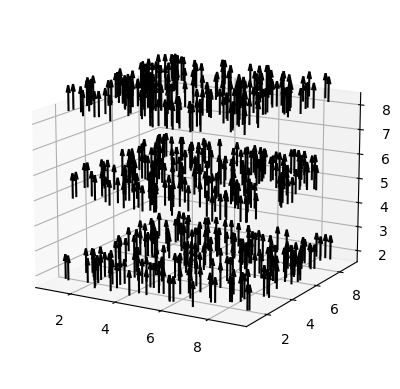

In [20]:
import freud
import matplotlib.pyplot as plt
import numpy as np
import rowan

def randomize_orientations(orientations, perturbation_magnitude):
    randomized_orientations = []
    for orientation in orientations:
        phi = np.random.uniform(0, 2 * np.pi)
        costheta = np.random.uniform(-1, 1)
        theta = np.arccos(costheta)

        perturbation = (
            np.array(
                [
                    np.sin(theta) * np.cos(phi),
                    np.sin(theta) * np.sin(phi),
                    np.cos(theta),
                ]
            )
            * perturbation_magnitude
        )

        new_orientation = orientation + perturbation
        # Normalize the new orientation vector to maintain unit length
        new_orientation /= np.linalg.norm(new_orientation)
        randomized_orientations.append(new_orientation)
    return np.array(randomized_orientations)


def generate_smectic_a_positions(
    num_particles, box_size, layer_thickness, particle_radius
):
    particles_per_layer = int(num_particles // (box_size / layer_thickness))
    num_layers = int(num_particles / particles_per_layer)

    positions = []

    for layer in range(num_layers):
        z = layer * layer_thickness + layer_thickness / 2
        particles_in_layer = 0

        while particles_in_layer < particles_per_layer:
            x = np.random.uniform(particle_radius, box_size - particle_radius)
            y = np.random.uniform(particle_radius, box_size - particle_radius)

            position = np.array([x, y, z])
            positions.append(position)
            particles_in_layer += 1

    return np.array(positions[:num_particles])


N = 600
box_size = 10
layer_thickness = 3.34
particle_radius = 1

points = generate_smectic_a_positions(N, box_size, layer_thickness, particle_radius)

orientations = np.asarray(
    [
        [0, 0, 1],
    ]
    * N
)

# make a 3D plot of the system
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.quiver3D(
    points[:, 0],
    points[:, 1],
    points[:, 2],
    orientations[:, 0],
    orientations[:, 1],
    orientations[:, 2],
    normalize=True,
    color="k",
)
# change angle of plot view
ax.view_init(elev=15)

To compute the smectic order parameter we use the following equation:
$$
P(d) = \frac{1}{N} \sum_j^N \exp( \frac{2\pi i}{d} \mathbf{n} \cdot \mathbf{r}_j) (6)
$$
where $d$ is the layer distance, $N$ is the number of particles and $\mathbf{r}$ is the position of particle. It is clear that this value is a function of layer distance $d$. Fortunately it is well known that at the appropriate layer distance $d$, the value of $P$ must be at a global maximum. Thus to find the true value of the smectic order parameter $P$ we simply optimize it as a function of $d$ to find the layer distance as well. A good introduction in how to compute smectic order parameters can be found in appendix of [this work](https://pubs.aip.org/aip/jcp/article/138/20/204901/566257/An-atomistic-description-of-the-nematic-and).  

In [21]:
import scipy.optimize


def calc_smectic(d, director, pos):
    return -(
        np.absolute(np.sum(np.exp(np.dot(director, pos.T) * 2 * np.pi * 1j / d)))
    ) / len(pos)


nematic = freud.order.Nematic()
nematic.compute(orientations)
# make sure the director is normalized
director = nematic.director / np.linalg.norm(nematic.director)
maximal_d = scipy.optimize.brute(
    calc_smectic,  # function to optimize
    ranges=(
        slice(layer_thickness * 0.4, layer_thickness * 1.8, 0.10),
    ),  # range of values for optimization, these depend on the size of the particles in the direction of orientation
    args=(director, points),  # arguments to pass to calc_smectic
    finish=scipy.optimize.fmin,  # use Nelder-Mead to refine the brute force result
)[0]
smec = -calc_smectic(maximal_d, director, points)
print(
    f"The value of the nematic order parameter is {nematic.order:.3f}, and the value of the smectic order parameter is {smec:.3f} and distance between the smectic layers is {maximal_d:.3f}."
)

The value of the nematic order parameter is 1.000, and the value of the smectic order parameter is 1.000 and distance between the smectic layers is 3.340.


As we can see the system has perfect nematic and perfect smectic order. The distance between the smectic layers determined from the smectic order parameter matches the layer thickness we used to construct the system in the first place. Now consider a system in which orientations are somewhat randomized and nematic order is not perfect, but smectic order still is. In this case smectic order parameter should still be close to 1, but nematic order should be much lower.

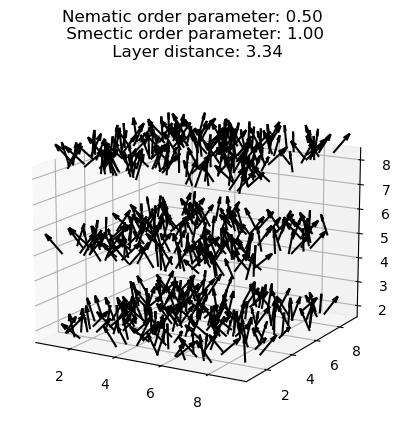

In [22]:
# generate positions and orientations
points = generate_smectic_a_positions(N, box_size, layer_thickness, particle_radius)
orientations = np.asarray(
    [
        [0, 0, 1],
    ]
    * N
)
# We randomly rotate the starting orientations by some amount
orientations = randomize_orientations(orientations, 0.75)
# compute the order paramters
nematic = freud.order.Nematic()
nematic.compute(orientations)
# make sure the director is normalized
director = nematic.director / np.linalg.norm(nematic.director)
maximal_d = scipy.optimize.brute(
    calc_smectic,  # function to optimize
    ranges=(
        slice(layer_thickness * 0.4, layer_thickness * 1.8, 0.10),
    ),  # range of values for optimization, these depend on the size of the particles in the direction of orientation
    args=(director, points),  # arguments to pass to calc_smectic
    finish=scipy.optimize.fmin,  # use Nelder-Mead to refine the brute force result
)[0]
smec = -calc_smectic(maximal_d, director, points)

# make a 3D plot of the system
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.set_title(
    f"Nematic order parameter: {nematic.order:.2f} \n Smectic order parameter: {smec:.2f} \n Layer distance: {maximal_d:.2f}"
)
ax.quiver3D(
    points[:, 0],
    points[:, 1],
    points[:, 2],
    orientations[:, 0],
    orientations[:, 1],
    orientations[:, 2],
    normalize=True,
    color="k",
)
# change angle of plot view
ax.view_init(elev=15)

now lets introduce noise in z position of our particles to get a more realistic system snapshot. Now both smecitc and nematic order should be between 0 and 1.

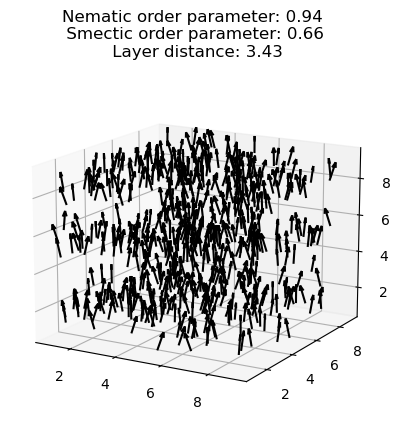

In [23]:
points = generate_smectic_a_positions(N, box_size, layer_thickness, particle_radius)
noise = np.random.normal(0, 0.5, N)
points[:, 2] = points[:, 2] + noise
# set up perfectly oriented system
orientations = np.asarray(
    [
        [0, 0, 1],
    ]
    * N
)
# We randomly rotate the starting orientations by some amount
orientations = randomize_orientations(orientations, 0.25)
# compute the order paramters
nematic = freud.order.Nematic()
nematic.compute(orientations)
# make sure the director is normalized
director = nematic.director / np.linalg.norm(nematic.director)
maximal_d = scipy.optimize.brute(
    calc_smectic,  # function to optimize
    ranges=(
        slice(layer_thickness * 0.4, layer_thickness * 1.8, 0.10),
    ),  # range of values for optimization, these depend on the size of the particles in the direction of orientation
    args=(director, points),  # arguments to pass to calc_smectic
    finish=scipy.optimize.fmin,  # use Nelder-Mead to refine the brute force result
)[0]
smec = -calc_smectic(maximal_d, director, points)

# make a 3D plot of the system
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.set_title(
    f"Nematic order parameter: {nematic.order:.2f} \n Smectic order parameter: {smec:.2f} \n Layer distance: {maximal_d:.2f}"
)
ax.quiver3D(
    points[:, 0],
    points[:, 1],
    points[:, 2],
    orientations[:, 0],
    orientations[:, 1],
    orientations[:, 2],
    normalize=True,
    color="k",
)
# change angle of plot view
ax.view_init(elev=15)